In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from matplotlib import pyplot as plt
from utils import get_mnist_data
from models import ConvNN
from training_and_evaluation import train_model, predict_model
from attacks import fast_gradient_attack
from torch.nn.functional import cross_entropy
import os
if not os.path.isdir("models"):
    os.mkdir("models")

# Project 2, part 1: Creating adversarial examples (50 pt)
In this notebook we train a basic convolutional neural network on MNIST and craft adversarial examples via gradient descent.

## Your task
Complete the missing code in the respective files, i.e. `training_and_evaluation.py`, `attacks.py`, and this notebook. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Specifically, for this part you will have to implement the following functions / classes:  
**`training_and_evaluation.py`**:
* `train_model` (15pt)
* `predict_model` (10pt)

**`attacks.py`**:
* `fast_gradient_attack` (15pt)

**This notebook**
* Cells in the Qualitative Evaluation section. (10pt)

## General remarks
Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

In [2]:
mnist_trainset = get_mnist_data(train=True)
mnist_testset = get_mnist_data(train=False)

use_cuda = torch.cuda.is_available() #and False

model = ConvNN()
if use_cuda:
    model = model.cuda()

epochs = 1
batch_size = 128
test_batch_size = 1000  # feel free to change this
lr = 1e-3

opt = Adam(model.parameters(), lr=lr)

In [3]:
def loss_function(x, y, model):
    logits = model(x).cpu()
    loss = cross_entropy(logits, y)
    return loss, logits

Implement the `train_model` function in the file `training_and_evaluation.py`.

In [4]:
losses, accuracies = train_model(model, mnist_trainset, batch_size=batch_size, loss_function=loss_function, optimizer=opt)

100%|██████████| 469/469 [00:10<00:00, 43.07it/s]


In [5]:
torch.save(model.state_dict(), "models/standard_training.checkpoint")

In [6]:
model.load_state_dict(torch.load("models/standard_training.checkpoint", map_location="cpu"))

<All keys matched successfully>

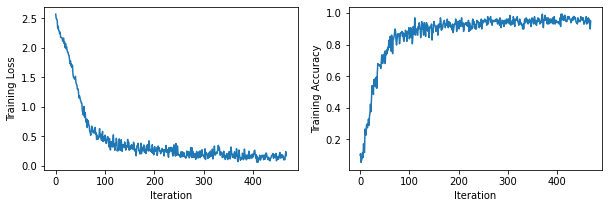

In [7]:
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.plot(accuracies)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.show()

Implement the `predict_model` function in the file `training_and_evaluation.py`.

In [8]:
clean_accuracy = predict_model(model, mnist_testset, batch_size=test_batch_size, attack_function=None)

100%|██████████| 10/10 [00:01<00:00,  9.66it/s]


### Creating adversarial examples
#### $L_2$-bounded attacks
Fist, craft adversarial perturbations that have a $L_2$ norm of $ \| \tilde{\mathbf{x}} - \mathbf{x} \|_2 = \epsilon$ with $\epsilon=5$.

#### $L_\infty$-bounded attacks
Afterwards, craft adversarial perturbations with $L_\infty$ norm of $ \| \tilde{\mathbf{x}} - \mathbf{x} \|_\infty = \epsilon$ with $\epsilon=0.3$.

For this you need to implement `predict_model` in the file `training_and_evaluation.py` and `fast_gradient_attack` in `attacks.py`. See the docstring comments there.

In [9]:
attack_args_l2 = {"epsilon": 5, "norm": "2"}
attack_args_linf = {"epsilon": 0.3, "norm": "inf"}

### Qualitative evaluation

First, craft adversarial examples for 10 randomly selected test samples and inspect them by plotting them.

$L_2$ attack:

In [10]:
test_loader = DataLoader(mnist_testset, batch_size = 10, shuffle=True)
x,y = next(iter(test_loader))
##########################################################
# YOUR CODE HERE

# fixme --- 

x.requires_grad = True

logits = model(x)
x_pert_l2 = fast_gradient_attack(logits, x, y, **attack_args_l2)

y_pert_l2 = torch.argmax(model(x_pert_l2), dim=-1)
##########################################################

$L_\infty$ attack:

In [11]:
##########################################################
# YOUR CODE HERE
x.requires_grad = True

logits = model(x)
x_pert_linf = fast_gradient_attack(logits, x, y, **attack_args_linf)

y_pert_linf = torch.argmax(model(x_pert_linf), dim=-1)
##########################################################

Visualize the adversarial examples and the model's prediction on them:

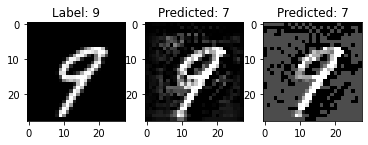

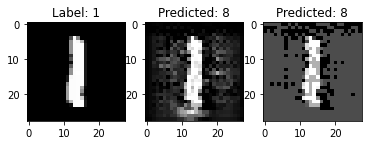

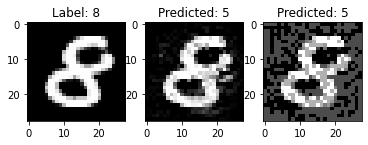

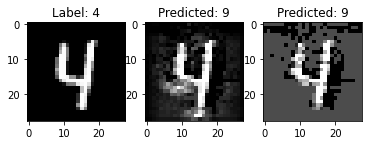

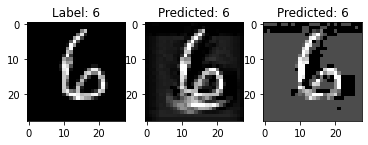

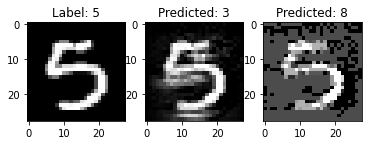

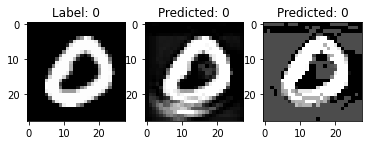

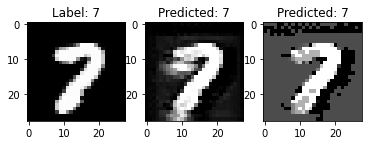

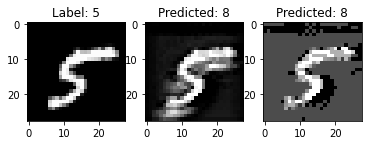

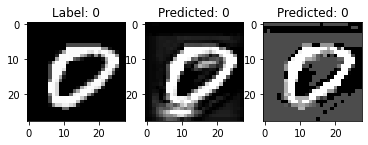

In [12]:
for ix in range(len(x)):
    plt.subplot(131)
    plt.imshow(x[ix,0].detach().cpu(), cmap="gray")
    plt.title(f"Label: {y[ix]}")
    plt.subplot(132)
    plt.imshow(x_pert_l2[ix,0].detach().cpu(), cmap="gray")
    plt.title(f"Predicted: {y_pert_l2[ix]}")
    
    plt.subplot(133)
    plt.imshow(x_pert_linf[ix,0].detach().cpu(), cmap="gray")
    plt.title(f"Predicted: {y_pert_linf[ix]}")
    plt.show()

### Quantitative evaluation
Perturb each test sample and compare the clean and perturbed accuracies.

$L_2$ perturbations:

In [13]:
perturbed_accuracy_l2 = predict_model(model, mnist_testset, batch_size=test_batch_size, attack_function=fast_gradient_attack, attack_args=attack_args_l2)

100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


$L_\infty$ perturbations:

In [14]:
perturbed_accuracy_linf = predict_model(model, mnist_testset, batch_size=test_batch_size, attack_function=fast_gradient_attack, attack_args=attack_args_linf)

100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Your values for `clean_accuracy` and `perturbed_accuracy` should roughly match the ones below, even though they will of course not be identical.

In [15]:
clean_accuracy

0.9580000042915344

In [16]:
perturbed_accuracy_l2

0.3424000144004822

In [17]:
perturbed_accuracy_linf

0.2754000127315521

#### In the remaining parts of this project we will be focusing on **$L_2$-based attacks only**.